In [2]:
import pandas as pd
import numpy as np

In [9]:
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")
cal_df = pd.read_parquet("../validationB_v3.parquet")

In [10]:
print(train_df.shape)
print(val_df.shape)
print(cal_df.shape)

(112768, 791)
(24164, 791)
(24164, 791)


In [11]:
train_df.iloc[:,:25].dtypes

category                            object
missing_price                         bool
item_rank                          float64
match                                int64
avg_rating                         float64
min_rating                           int64
percent_positive                   float64
percent_negative                   float64
avg_verified_reviewers             float64
min_date                    datetime64[ns]
max_date                    datetime64[ns]
product_lifespan           timedelta64[ns]
num_bots_per_asin                    int64
unique_reviewer_count                int64
avg_reviews_per_day                float64
reviews_per_product                  int64
avg_review_length_words            float64
embed_0                            float64
embed_1                            float64
embed_2                            float64
embed_3                            float64
embed_4                            float64
embed_5                            float64
embed_6    

In [12]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']
X_cal = cal_df.drop(columns=['match'])
y_cal = cal_df['match']

In [13]:
X_train_raw = X_train
X_val_raw = X_val
X_test_raw = X_cal

## Columns Type Updated

In [14]:
for df in (X_train, X_val, X_cal):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val, X_cal):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val, X_cal):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}, X_cal: {X_cal.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789), X_cal: (24164, 789)


We will drop the columns `percent_positive`, `percent_negative`,  `review_span ` and `unique_reviewer_count` as they exhibit high correlation with other features, which may introduce multicollinearity into the model.

In [15]:
for df in (X_train, X_val, X_cal):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

## Preprocessing, PCA

In [16]:
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


def make_transformer(df,r, s, drop_first=True):
    rev_cols  = [c for c in df if c.startswith("embedding_")]
    summ_cols = [c for c in df if c.startswith("embed_")]
    numeric_cols  = [c for c in df if c not in rev_cols+summ_cols+["category"]]

    rev_pipe  = ("drop" if r == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=r,random_state=42))]))
    sum_pipe  = ("drop" if s == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=s,random_state=42))]))

    return ColumnTransformer(
        [('num', StandardScaler(), numeric_cols),
         ('cat', OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False), ["category"]),
         ('rev', rev_pipe,  rev_cols),
         ('sum', sum_pipe,  summ_cols)
        ]).set_output(transform="pandas")

In [17]:
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_cal_proc = preprocessor.transform(X_cal)

In [18]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

## Multicollinearity: Variance Inflation Factor (VIF) On Non-Embedding Features:

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X_train_proc, numeric_cols, categorical_cols, thresh=10):
    nonembed_cols = numeric_cols + categorical_cols
    X_vif = X_train_proc[nonembed_cols].copy()

    # drop constant / near-constant columns
    const_cols = X_vif.columns[X_vif.std() < 1e-12]
    if len(const_cols):
        X_vif.drop(columns=const_cols, inplace=True)

    # VIF calculation 
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    # Print features with VIF > 10
    high_vif = vif_data[vif_data["VIF"] > thresh].sort_values("VIF", ascending=False)
    if not high_vif.empty:
        print(f"Features with VIF > {thresh}:")
        print(high_vif.to_string(index=False))
    else:
        print(f"No features with VIF > {thresh}")

    return vif_data

In [20]:
vif_data = compute_vif(X_train_proc, num_cols, cat_cols, thresh=10)

No features with VIF > 10


## Custom KFold

In [21]:
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

In [23]:
import sys
sys.path.insert(0, '../Data/')
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

### GridSearchCV on r and s (The PCA dimension of Review and Summary Embeddings)

In [95]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, average_precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ("fe", make_transformer(X_train, r=50, s=10)),  # Dummy values, will be overridden by grid search
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

grid_vals = [10, 20, 50, 100]
param_grid = {
    "fe__rev__pca__n_components": grid_vals,  # r
    "fe__sum__pca__n_components": grid_vals   # s
}

scorers = {
    "pr_auc": make_scorer(average_precision_score, needs_proba=True),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
}

# Run GridSearchCV
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorers,
    refit="recall_macro",  
    cv=kfold,              
    n_jobs=20,
    return_train_score=False,
    verbose=1
)

# Fit
gcv.fit(X_train, y_train)  

# Extract results
results = (
    pd.DataFrame(gcv.cv_results_)
    .loc[:, [
        "param_fe__rev__pca__n_components",
        "param_fe__sum__pca__n_components",
        "mean_test_pr_auc", "std_test_pr_auc",
        "mean_test_recall_macro", "std_test_recall_macro",
        "mean_test_f1_macro", "std_test_f1_macro"
    ]]
    .rename(columns={
        "param_fe__rev__pca__n_components": "r",
        "param_fe__sum__pca__n_components": "s",
        "mean_test_pr_auc": "pr_auc_mean",
        "std_test_pr_auc": "pr_auc_std",
        "mean_test_recall_macro": "recall_macro_mean",
        "std_test_recall_macro": "recall_macro_std",
        "mean_test_f1_macro": "f1_macro_mean",
        "std_test_f1_macro": "f1_macro_std"
    })
    .sort_values("recall_macro_mean", ascending=False)
    .reset_index(drop=True)
)

print(results.head())

# Best model ready to use
best_lr = gcv.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


     r    s  pr_auc_mean  pr_auc_std  recall_macro_mean  recall_macro_std  \
0   50   10     0.041231    0.011392           0.639404          0.047560   
1  100   50     0.034951    0.009601           0.636770          0.044809   
2   50   20     0.041029    0.011711           0.634945          0.046026   
3  100   10     0.037633    0.009054           0.634354          0.048340   
4  100  100     0.033521    0.009815           0.632194          0.037666   

   f1_macro_mean  f1_macro_std  
0       0.469341      0.004529  
1       0.476090      0.004948  
2       0.468916      0.004182  
3       0.474171      0.004917  
4       0.477608      0.004493  


From the results, we observe that there is not much difference between the different values of r and s. So, we will choose r = 50 and s = 10 since with these values model performs best.

## Feature Selection With Logistic Regression

#### Preprocessing with r=50, s=10

In [25]:
preprocessor = make_transformer(X_train, r=50, s=10)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
# update columns names
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

print(f"After preprocessing X_train_proc:", X_train_proc.shape)
print(f"After preprocessing X_val_proc:", X_val_proc.shape)

After preprocessing X_train_proc: (112768, 95)
After preprocessing X_val_proc: (24164, 95)


In [99]:
from sklearn.feature_selection import SelectFromModel

l1_model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', C=0.1, random_state=42)
l1_model.fit(X_train_proc, y_train)

selector = SelectFromModel(l1_model, prefit=True)
X_train_sel = selector.transform(X_train_proc)
selected_feats = X_train_proc.columns[selector.get_support()]

print(f"Selected {len(selected_feats)} features:")

Selected 95 features:
['num__missing_price', 'num__item_rank', 'num__avg_rating', 'num__min_rating', 'num__avg_verified_reviewers', 'num__num_bots_per_asin', 'num__avg_reviews_per_day', 'num__reviews_per_product', 'num__avg_review_length_words', 'num__mean_sentiment_score', 'num__mean_complaint_similarity', 'num__mean_shipping_similarity', 'num__max_complaint_similarity', 'num__shipping_similarity_at_max_complaint', 'num__sentiment_score_at_max_complaint', 'num__product_lifespan_days', 'cat__category_Arts & Crafts', 'cat__category_Baby & Toddler Toys', 'cat__category_Building Toys', 'cat__category_Dolls & Accessories', 'cat__category_Dress Up & Pretend Play', 'cat__category_Games', 'cat__category_Grown-Up Toys', 'cat__category_Hobbies', "cat__category_Kids' Electronics", "cat__category_Kids' Furniture, Dcor & Storage", 'cat__category_Learning & Education', 'cat__category_Novelty & Gag Toys', 'cat__category_Party Supplies', 'cat__category_Puppets', 'cat__category_Puzzles', 'cat__categor

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


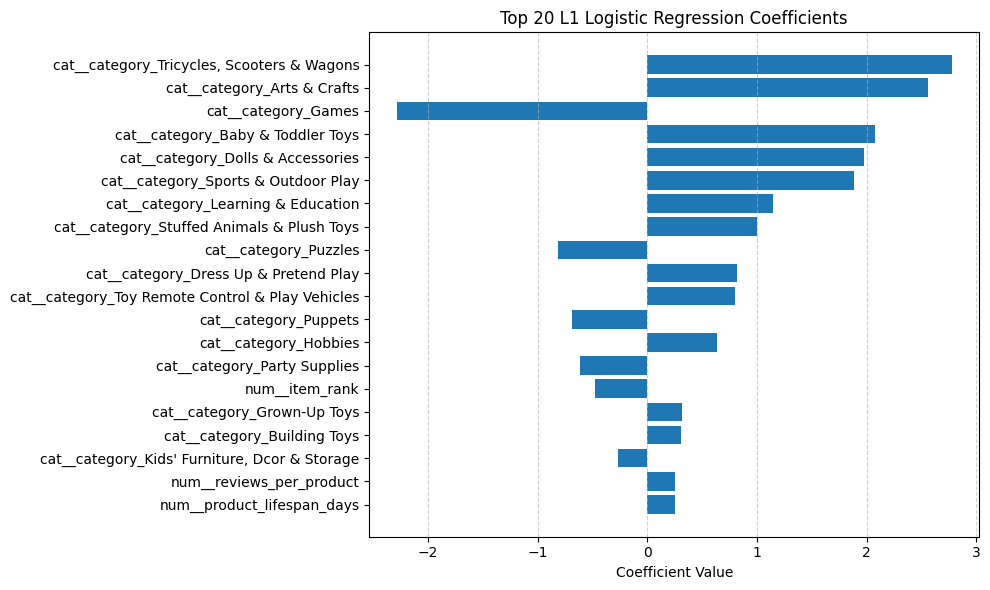

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get coefficients and feature names
coefs = l1_model.coef_[0]
feature_names = X_train_proc.columns

# Create a DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})

# Get top 20 features by absolute coefficient
top20 = coef_df.sort_values(by='abs_coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20['feature'][::-1], top20['coefficient'][::-1])
plt.title('Top 20 L1 Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

It looks like category features are very important. We will drop category features and regenerate the featue importance.

In [31]:
# Drop category columns
X_train_proc_wo_cat = X_train_proc.drop(columns=cat_cols, axis=1)
X_val_proc_wo_cat = X_val_proc.drop(columns=cat_cols, axis=1)

print(f"After dropping categorical columns from train dataframe:", X_train_proc_wo_cat.shape)
print(f"After dropping categorical columns from val dataframe:", X_val_proc_wo_cat.shape)

After dropping categorical columns from train dataframe: (112768, 76)
After dropping categorical columns from val dataframe: (24164, 76)


In [107]:
l1_model.fit(X_train_proc_wo_cat, y_train)

selector = SelectFromModel(l1_model, prefit=True)
X_train_sel = selector.transform(X_train_proc_wo_cat)
selected_feats = X_train_proc_wo_cat.columns[selector.get_support()]

print(f"Selected {len(selected_feats)} features:")
print(selected_feats.tolist())


Selected 76 features:
['num__missing_price', 'num__item_rank', 'num__avg_rating', 'num__min_rating', 'num__avg_verified_reviewers', 'num__num_bots_per_asin', 'num__avg_reviews_per_day', 'num__reviews_per_product', 'num__avg_review_length_words', 'num__mean_sentiment_score', 'num__mean_complaint_similarity', 'num__mean_shipping_similarity', 'num__max_complaint_similarity', 'num__shipping_similarity_at_max_complaint', 'num__sentiment_score_at_max_complaint', 'num__product_lifespan_days', 'rev__pca0', 'rev__pca1', 'rev__pca2', 'rev__pca3', 'rev__pca4', 'rev__pca5', 'rev__pca6', 'rev__pca7', 'rev__pca8', 'rev__pca9', 'rev__pca10', 'rev__pca11', 'rev__pca12', 'rev__pca13', 'rev__pca14', 'rev__pca15', 'rev__pca16', 'rev__pca17', 'rev__pca18', 'rev__pca19', 'rev__pca20', 'rev__pca21', 'rev__pca22', 'rev__pca23', 'rev__pca24', 'rev__pca25', 'rev__pca26', 'rev__pca27', 'rev__pca28', 'rev__pca29', 'rev__pca30', 'rev__pca31', 'rev__pca32', 'rev__pca33', 'rev__pca34', 'rev__pca35', 'rev__pca36', '

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


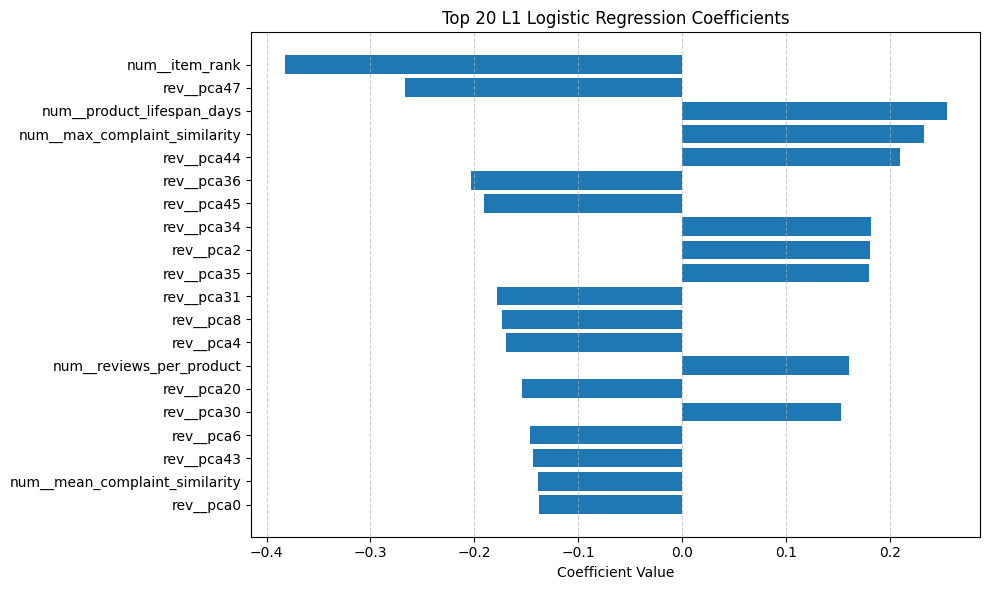

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get coefficients and feature names
coefs = l1_model.coef_[0]
feature_names = X_val_proc_wo_cat.columns

# Create a DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})

# Get top 20 features by absolute coefficient
top20 = coef_df.sort_values(by='abs_coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20['feature'][::-1], top20['coefficient'][::-1])
plt.title('Top 20 L1 Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [109]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(log_reg, X_train_proc_wo_cat, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())

Macro Recall (per fold): [0.70969658 0.61741045 0.65258122]
Mean Macro Recall: 0.659896083803898


In [112]:
log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', class_weight="balanced", random_state=42)
log_reg.fit(X_train_proc_wo_cat, y_train)

y_pred = log_reg.predict(X_val_proc_wo_cat)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.7825277271974839
Confusion Matrix:
 [[18788  5212]
 [   43   121]]
Macro Recall: 0.760319105691057


### Logistic Regression Gridsearchcv

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def run_logreg_gridsearch(X, y, cv, verbose=2, n_jobs=20):
    base_model = LogisticRegression(max_iter=1000, random_state=42)

    param_grid = [
        {
            'penalty': ['l1'],
            'solver': ['liblinear', 'saga'],
            'C': [0.01, 0.1, 1.0, 10.0],
            'class_weight': [None, 'balanced', {0: 1, 1: 600}]
        },
        {
            'penalty': ['l2'],
            'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
            'C': [0.01, 0.1, 1.0, 10.0],
            'class_weight': [None, 'balanced', {0: 1, 1: 600}]
        },
        {
            'penalty': [None],
            'solver': ['lbfgs', 'saga', 'newton-cg'],
            'class_weight': [None, 'balanced', {0: 1, 1: 600}]
        }
    ]

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)
    top_cols = [
        'param_penalty', 'param_solver', 'param_C', 'param_class_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]
    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [74]:
# without category
gcv_logreg_wo_cat, results_logreg_wo_cat = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
   param_penalty param_solver  param_C param_class_weight  \
11            l1         saga     0.10     {0: 1, 1: 600}   
34            l2        lbfgs     0.01     {0: 1, 1: 600}   
32            l2    liblinear     0.01     {0: 1, 1: 600}   
70            l2        lbfgs    10.00     {0: 1, 1: 600}   
58            l2        lbfgs     1.00     {0: 1, 1: 600}   
35            l2    newton-cg     0.01     {0: 1, 1: 600}   
78          None        lbfgs      NaN     {0: 1, 1: 600}   
22            l1    liblinear    10.00     {0: 1, 1: 600}   
56            l2    liblinear     1.00     {0: 1, 1: 600}   
68            l2    liblinear    10.00     {0: 1, 1: 600}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
11                0.680299            0.355908          0.019306  
34                0.677889            0.360796          0.035903  
32                0.677726            0.360653          0.035897 

In [76]:
# with category
gcv_logreg, results_logreg = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
   param_penalty param_solver  param_C param_class_weight  \
23            l1         saga    10.00     {0: 1, 1: 600}   
34            l2        lbfgs     0.01     {0: 1, 1: 600}   
35            l2    newton-cg     0.01     {0: 1, 1: 600}   
32            l2    liblinear     0.01     {0: 1, 1: 600}   
4             l1    liblinear     0.01     {0: 1, 1: 600}   
46            l2        lbfgs     0.10     {0: 1, 1: 600}   
44            l2    liblinear     0.10     {0: 1, 1: 600}   
78          None        lbfgs      NaN     {0: 1, 1: 600}   
10            l1    liblinear     0.10     {0: 1, 1: 600}   
47            l2    newton-cg     0.10     {0: 1, 1: 600}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
23                0.667345            0.387939          0.018447  
34                0.660678            0.393938          0.039588  
35                0.659946            0.393857          0.039641 

In [77]:
# with smote
gcv_logreg_smote, results_logreg_smote = run_logreg_gridsearch(X_smote, y_smote, cv=kfold)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
   param_penalty param_solver  param_C param_class_weight  \
23            l1         saga    10.00     {0: 1, 1: 600}   
34            l2        lbfgs     0.01     {0: 1, 1: 600}   
35            l2    newton-cg     0.01     {0: 1, 1: 600}   
32            l2    liblinear     0.01     {0: 1, 1: 600}   
4             l1    liblinear     0.01     {0: 1, 1: 600}   
46            l2        lbfgs     0.10     {0: 1, 1: 600}   
44            l2    liblinear     0.10     {0: 1, 1: 600}   
78          None        lbfgs      NaN     {0: 1, 1: 600}   
10            l1    liblinear     0.10     {0: 1, 1: 600}   
47            l2    newton-cg     0.10     {0: 1, 1: 600}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
23                0.667345            0.387939          0.018447  
34                0.660678            0.393938          0.039588  
35                0.659946            0.393857          0.039641 

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_logreg_gridsearch(X, y, cv, class_weight_options, verbose=2, n_jobs=20):
    
    base_model = LogisticRegression(max_iter=1000, random_state=42)

    param_grid = []

    # L1 penalty
    param_grid.append({
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1.0, 10.0],
        'class_weight': class_weight_options
    })

    # L2 penalty
    param_grid.append({
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
        'C': [0.01, 0.1, 1.0, 10.0],
        'class_weight': class_weight_options
    })

    # No penalty (aka penalty=None)
    param_grid.append({
        'penalty': [None],
        'solver': ['lbfgs', 'saga', 'newton-cg'],
        'class_weight': class_weight_options
    })

    # Scorers
    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    # GridSearchCV
    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)
    top_cols = [
        'param_penalty', 'param_solver', 'param_C', 'param_class_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]
    print(results[top_cols].head(10))
    return gcv, results[top_cols]

We will apply separate gridsearchcv for each class weights:

#### Logistic Regression, Without Category Columns, With Different Class Weights:

In [66]:
# without category class weight balanced gridsearch_cv:
n_jobs=20
class_weight_options = ['balanced']
gcv_log_reg_wo_category_balanced, results_log_reg_wo_category_balanced = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
5             l1         saga     1.00           balanced   
21            l2         saga    10.00           balanced   
20            l2    liblinear    10.00           balanced   
19            l2    newton-cg     1.00           balanced   
6             l1    liblinear    10.00           balanced   
16            l2    liblinear     1.00           balanced   
15            l2    newton-cg     0.10           balanced   
12            l2    liblinear     0.10           balanced   
8             l2    liblinear     0.01           balanced   
26          None    newton-cg      NaN           balanced   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
5                 0.672709            0.459832          0.043090  
21                0.663394            0.456234          0.028334  
20                0.660567            0.465140          0.036856  

In [74]:
# test gridsearch_cv results with validation set
import importlib              
import evaluator               
importlib.reload(evaluator)   
from evaluator import evaluate_param_list
val_results = evaluate_param_list(results_log_reg_wo_category_balanced, gcv_log_reg_wo_category_balanced.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
0,l1,saga,1.00,balanced,0.770313,0.457281,0.027055,"[[18536, 5464], [38, 126]]"
1,l2,saga,10.00,balanced,0.767306,0.457135,0.026743,"[[18538, 5462], [39, 125]]"
2,l2,liblinear,10.00,balanced,0.760340,0.460683,0.023598,"[[18789, 5211], [43, 121]]"
3,l2,newton-cg,1.00,balanced,0.760340,0.460683,0.023595,"[[18789, 5211], [43, 121]]"
4,l1,liblinear,10.00,balanced,0.760340,0.460683,0.023598,"[[18789, 5211], [43, 121]]"
5,l2,liblinear,1.00,balanced,0.760340,0.460683,0.023598,"[[18789, 5211], [43, 121]]"
9,None,newton-cg,NaN,balanced,0.760340,0.460683,0.023595,"[[18789, 5211], [43, 121]]"
6,l2,newton-cg,0.10,balanced,0.760319,0.460666,0.023597,"[[18788, 5212], [43, 121]]"
7,l2,liblinear,0.10,balanced,0.760298,0.460649,0.023601,"[[18787, 5213], [43, 121]]"
8,l2,liblinear,0.01,balanced,0.759652,0.460119,0.023647,"[[18756, 5244], [43, 121]]"


In [76]:
# without category class weight 250 gridsearch_cv:
class_weight_options = [{0: 1, 1: 250}]
gcv_log_reg_wo_category_250, results_log_reg_wo_category_250 = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
25          None         saga      NaN     {0: 1, 1: 250}   
22            l2        lbfgs    10.00     {0: 1, 1: 250}   
24          None        lbfgs      NaN     {0: 1, 1: 250}   
15            l2    newton-cg     0.10     {0: 1, 1: 250}   
18            l2        lbfgs     1.00     {0: 1, 1: 250}   
12            l2    liblinear     0.10     {0: 1, 1: 250}   
10            l2        lbfgs     0.01     {0: 1, 1: 250}   
14            l2        lbfgs     0.10     {0: 1, 1: 250}   
23            l2    newton-cg    10.00     {0: 1, 1: 250}   
26          None    newton-cg      NaN     {0: 1, 1: 250}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
25                0.676320            0.417295          0.027960  
22                0.671754            0.430850          0.036944  
24                0.671736            0.430835          0.036926  

In [79]:
val_results = evaluate_param_list(results_log_reg_wo_category_250, gcv_log_reg_wo_category_250.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
3,l2,newton-cg,0.10,"{0: 1, 1: 250}",0.769316,0.421731,0.022779,"[[16293, 7707], [23, 141]]"
8,l2,newton-cg,10.00,"{0: 1, 1: 250}",0.769316,0.421731,0.022778,"[[16293, 7707], [23, 141]]"
9,None,newton-cg,NaN,"{0: 1, 1: 250}",0.769316,0.421731,0.022778,"[[16293, 7707], [23, 141]]"
5,l2,liblinear,0.10,"{0: 1, 1: 250}",0.769295,0.421714,0.022780,"[[16292, 7708], [23, 141]]"
7,l2,lbfgs,0.10,"{0: 1, 1: 250}",0.769274,0.421697,0.022797,"[[16291, 7709], [23, 141]]"
1,l2,lbfgs,10.00,"{0: 1, 1: 250}",0.769211,0.421646,0.022802,"[[16288, 7712], [23, 141]]"
2,None,lbfgs,NaN,"{0: 1, 1: 250}",0.769191,0.421629,0.022799,"[[16287, 7713], [23, 141]]"
4,l2,lbfgs,1.00,"{0: 1, 1: 250}",0.769191,0.421629,0.022799,"[[16287, 7713], [23, 141]]"
6,l2,lbfgs,0.01,"{0: 1, 1: 250}",0.769170,0.421612,0.022803,"[[16286, 7714], [23, 141]]"
0,None,saga,NaN,"{0: 1, 1: 250}",0.641566,0.414106,0.010681,"[[16161, 7839], [64, 100]]"


In [80]:
# without category class weight 400 gridsearch_cv:
class_weight_options = [{0: 1, 1: 400}]
gcv_log_reg_wo_category_400, results_log_reg_wo_category_400 = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
3             l1         saga      0.1     {0: 1, 1: 400}   
22            l2        lbfgs     10.0     {0: 1, 1: 400}   
6             l1    liblinear     10.0     {0: 1, 1: 400}   
20            l2    liblinear     10.0     {0: 1, 1: 400}   
24          None        lbfgs      NaN     {0: 1, 1: 400}   
18            l2        lbfgs      1.0     {0: 1, 1: 400}   
16            l2    liblinear      1.0     {0: 1, 1: 400}   
4             l1    liblinear      1.0     {0: 1, 1: 400}   
12            l2    liblinear      0.1     {0: 1, 1: 400}   
15            l2    newton-cg      0.1     {0: 1, 1: 400}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
3                 0.695565            0.391066          0.019512  
22                0.683337            0.395570          0.036364  
6                 0.683330            0.395564          0.036411  

In [81]:
val_results = evaluate_param_list(results_log_reg_wo_category_400, gcv_log_reg_wo_category_400.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
4,None,lbfgs,NaN,"{0: 1, 1: 400}",0.746734,0.380878,0.022075,"[[13892, 10108], [14, 150]]"
5,l2,lbfgs,1.0,"{0: 1, 1: 400}",0.746734,0.380878,0.022075,"[[13892, 10108], [14, 150]]"
1,l2,lbfgs,10.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022077,"[[13891, 10109], [14, 150]]"
2,l1,liblinear,10.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022060,"[[13891, 10109], [14, 150]]"
3,l2,liblinear,10.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022060,"[[13891, 10109], [14, 150]]"
6,l2,liblinear,1.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022060,"[[13891, 10109], [14, 150]]"
9,l2,newton-cg,0.1,"{0: 1, 1: 400}",0.746713,0.380860,0.022066,"[[13891, 10109], [14, 150]]"
7,l1,liblinear,1.0,"{0: 1, 1: 400}",0.746671,0.380824,0.022061,"[[13889, 10111], [14, 150]]"
8,l2,liblinear,0.1,"{0: 1, 1: 400}",0.746650,0.380806,0.022059,"[[13888, 10112], [14, 150]]"
0,l1,saga,0.1,"{0: 1, 1: 400}",0.674792,0.379425,0.014028,"[[13951, 10049], [38, 126]]"


#### Best Models When Categorical Columns Are Excluded

In [ ]:
model_1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_2 = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_3 = LogisticRegression(penalty=None, solver='lbfgs', class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

#### Logistic Regression, With Category Columns, With Different Class Weights:

In [90]:
#class weight balanced
class_weight_options = ['balanced']
gcv_log_reg_balanced, results_log_reg_balanced = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
11            l2    newton-cg     0.01           balanced   
10            l2        lbfgs     0.01           balanced   
8             l2    liblinear     0.01           balanced   
15            l2    newton-cg     0.10           balanced   
12            l2    liblinear     0.10           balanced   
0             l1    liblinear     0.01           balanced   
14            l2        lbfgs     0.10           balanced   
2             l1    liblinear     0.10           balanced   
18            l2        lbfgs     1.00           balanced   
19            l2    newton-cg     1.00           balanced   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
11                0.642686            0.470241          0.039159  
10                0.642675            0.470233          0.039152  
8                 0.642023            0.469240          0.039360  

In [91]:
val_results = evaluate_param_list(results_log_reg_balanced, gcv_log_reg_balanced.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
9,l2,newton-cg,1.00,balanced,0.782598,0.469883,0.032523,"[[19272, 4728], [39, 125]]"
8,l2,lbfgs,1.00,balanced,0.782535,0.469830,0.032668,"[[19269, 4731], [39, 125]]"
7,l1,liblinear,0.10,balanced,0.780007,0.470069,0.032336,"[[19294, 4706], [40, 124]]"
3,l2,newton-cg,0.10,balanced,0.779820,0.469909,0.032123,"[[19285, 4715], [40, 124]]"
4,l2,liblinear,0.10,balanced,0.779736,0.469838,0.032097,"[[19281, 4719], [40, 124]]"
6,l2,lbfgs,0.10,balanced,0.776729,0.469669,0.032066,"[[19283, 4717], [41, 123]]"
5,l1,liblinear,0.01,balanced,0.773618,0.469410,0.030445,"[[19280, 4720], [42, 122]]"
2,l2,liblinear,0.01,balanced,0.773305,0.469145,0.029665,"[[19265, 4735], [42, 122]]"
0,l2,newton-cg,0.01,balanced,0.771090,0.469646,0.029671,"[[19305, 4695], [43, 121]]"
1,l2,lbfgs,0.01,balanced,0.771027,0.469593,0.029724,"[[19302, 4698], [43, 121]]"


In [94]:
# class weight 250
class_weight_options = [{0: 1, 1: 250}]
gcv_log_reg_250, results_log_reg_250 = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
17            l2         saga      1.0     {0: 1, 1: 250}   
2             l1    liblinear      0.1     {0: 1, 1: 250}   
4             l1    liblinear      1.0     {0: 1, 1: 250}   
16            l2    liblinear      1.0     {0: 1, 1: 250}   
19            l2    newton-cg      1.0     {0: 1, 1: 250}   
6             l1    liblinear     10.0     {0: 1, 1: 250}   
20            l2    liblinear     10.0     {0: 1, 1: 250}   
26          None    newton-cg      NaN     {0: 1, 1: 250}   
23            l2    newton-cg     10.0     {0: 1, 1: 250}   
18            l2        lbfgs      1.0     {0: 1, 1: 250}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
17                0.666395            0.425192          0.022726  
2                 0.653578            0.444624          0.041485  
4                 0.653567            0.444613          0.041509  

In [97]:
val_results = evaluate_param_list(results_log_reg_250, gcv_log_reg_250.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
2,l1,liblinear,1.0,"{0: 1, 1: 250}",0.793086,0.441053,0.032878,"[[17434, 6566], [23, 141]]"
5,l1,liblinear,10.0,"{0: 1, 1: 250}",0.793086,0.441053,0.032904,"[[17434, 6566], [23, 141]]"
6,l2,liblinear,10.0,"{0: 1, 1: 250}",0.793086,0.441053,0.032904,"[[17434, 6566], [23, 141]]"
3,l2,liblinear,1.0,"{0: 1, 1: 250}",0.793045,0.441019,0.032880,"[[17432, 6568], [23, 141]]"
8,l2,newton-cg,10.0,"{0: 1, 1: 250}",0.793045,0.441019,0.032874,"[[17432, 6568], [23, 141]]"
4,l2,newton-cg,1.0,"{0: 1, 1: 250}",0.793024,0.441002,0.032864,"[[17431, 6569], [23, 141]]"
7,None,newton-cg,NaN,"{0: 1, 1: 250}",0.793024,0.441002,0.032864,"[[17431, 6569], [23, 141]]"
9,l2,lbfgs,1.0,"{0: 1, 1: 250}",0.793024,0.441002,0.033009,"[[17431, 6569], [23, 141]]"
1,l1,liblinear,0.1,"{0: 1, 1: 250}",0.790079,0.440934,0.032797,"[[17436, 6564], [24, 140]]"
0,l2,saga,1.0,"{0: 1, 1: 250}",0.770857,0.422987,0.031878,"[[16367, 7633], [23, 141]]"


In [98]:
# class weight 400
class_weight_options = [{0: 1, 1: 400}]
gcv_log_reg_400, results_log_reg_400 = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
13            l2         saga     0.10     {0: 1, 1: 400}   
5             l1         saga     1.00     {0: 1, 1: 400}   
8             l2    liblinear     0.01     {0: 1, 1: 400}   
11            l2    newton-cg     0.01     {0: 1, 1: 400}   
10            l2        lbfgs     0.01     {0: 1, 1: 400}   
22            l2        lbfgs    10.00     {0: 1, 1: 400}   
18            l2        lbfgs     1.00     {0: 1, 1: 400}   
26          None    newton-cg      NaN     {0: 1, 1: 400}   
24          None        lbfgs      NaN     {0: 1, 1: 400}   
23            l2    newton-cg    10.00     {0: 1, 1: 400}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
13                0.696614            0.404962          0.024020  
5                 0.666294            0.400740          0.016400  
8                 0.659096            0.417538          0.039639  

In [99]:
val_results = evaluate_param_list(results_log_reg_400, gcv_log_reg_400.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
6,l2,lbfgs,1.00,"{0: 1, 1: 400}",0.776886,0.411320,0.033072,"[[15632, 8368], [16, 148]]"
8,None,lbfgs,NaN,"{0: 1, 1: 400}",0.776886,0.411320,0.033072,"[[15632, 8368], [16, 148]]"
7,None,newton-cg,NaN,"{0: 1, 1: 400}",0.776720,0.411182,0.032913,"[[15624, 8376], [16, 148]]"
9,l2,newton-cg,10.00,"{0: 1, 1: 400}",0.776699,0.411165,0.032942,"[[15623, 8377], [16, 148]]"
5,l2,lbfgs,10.00,"{0: 1, 1: 400}",0.776615,0.411096,0.032983,"[[15619, 8381], [16, 148]]"
4,l2,lbfgs,0.01,"{0: 1, 1: 400}",0.774053,0.408972,0.031299,"[[15496, 8504], [16, 148]]"
3,l2,newton-cg,0.01,"{0: 1, 1: 400}",0.773970,0.408903,0.031138,"[[15492, 8508], [16, 148]]"
2,l2,liblinear,0.01,"{0: 1, 1: 400}",0.773490,0.408505,0.031126,"[[15469, 8531], [16, 148]]"
1,l1,saga,1.00,"{0: 1, 1: 400}",0.727850,0.397132,0.018397,"[[14888, 9112], [27, 137]]"
0,l2,saga,0.10,"{0: 1, 1: 400}",0.706828,0.386797,0.016676,"[[14318, 9682], [30, 134]]"


### Best Models When Categorical Columns Are Included

In [ ]:
model_4 = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

## Random Forest Classifier

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_rf_gridsearch(X, y, cv, class_weight_options, verbose=2, n_jobs=20):

    rf_defaults = dict(random_state=42, n_jobs=n_jobs)

    base_model = RandomForestClassifier(**rf_defaults)

    param_grid = {
        'n_estimators': [300, 400],
        'class_weight': class_weight_options,
        'max_depth': [5, 7, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [3, 5],
        'max_features': ['sqrt', 'log2']
    }

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)

    top_cols = [
        'param_n_estimators', 'param_class_weight', 'param_max_depth',
        'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]

    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [106]:
# Class Weight, Balanced 
rf_class_weights = ['balanced']
gcv_rf_balanced, results_rf_balanced = run_rf_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
    param_n_estimators param_class_weight  param_max_depth  \
11                 400           balanced                5   
15                 400           balanced                5   
13                 400           balanced                5   
10                 300           balanced                5   
14                 300           balanced                5   
12                 300           balanced                5   
8                  300           balanced                5   
9                  400           balanced                5   
0                  300           balanced                5   
7                  400           balanced                5   

    param_min_samples_split  param_min_samples_leaf param_max_features  \
11                       10                       3               log2   
15                       10                       5               log2   
13                        5      

In [115]:
val_results = evaluate_param_list(results_rf_balanced, gcv_rf_balanced.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,n_estimators,class_weight,max_depth,min_samples_split,min_samples_leaf,max_features,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
3,300,balanced,5,10,3,log2,0.763171,0.492635,0.055230,"[[20681, 3319], [55, 109]]"
4,300,balanced,5,10,5,log2,0.763067,0.492533,0.055485,"[[20676, 3324], [55, 109]]"
5,300,balanced,5,5,5,log2,0.763067,0.492533,0.055485,"[[20676, 3324], [55, 109]]"
6,300,balanced,5,5,3,log2,0.762963,0.492431,0.055239,"[[20671, 3329], [55, 109]]"
0,400,balanced,5,10,3,log2,0.762734,0.492206,0.055624,"[[20660, 3340], [55, 109]]"
1,400,balanced,5,10,5,log2,0.762671,0.492145,0.055737,"[[20657, 3343], [55, 109]]"
2,400,balanced,5,5,5,log2,0.762671,0.492145,0.055737,"[[20657, 3343], [55, 109]]"
7,400,balanced,5,5,3,log2,0.762484,0.491962,0.055376,"[[20648, 3352], [55, 109]]"
9,400,balanced,5,10,5,sqrt,0.746879,0.492892,0.054717,"[[20777, 3223], [61, 103]]"
8,300,balanced,5,5,3,sqrt,0.746170,0.492200,0.053135,"[[20743, 3257], [61, 103]]"


In [ ]:
# Class Weight, 250 
rf_class_weights = [{0: 1.0, 1: 250.0}]
gcv_rf_250, results_rf_250 = run_rf_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [ ]:
val_results = evaluate_param_list(results_rf_250, gcv_rf_250.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

In [ ]:
# Class Weight, 400 
rf_class_weights = [{0: 1.0, 1: 400.0}]
gcv_rf_400, results_rf_400 = run_rf_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

In [ ]:
val_results = evaluate_param_list(results_rf_400, gcv_rf_400.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

#### Best Models With Random Forest Classifier

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_xgb_gridsearch(X, y, cv, scale_pos_weight_options, verbose=2, n_jobs=20):

    base_model = XGBClassifier(
        n_estimators=300,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=n_jobs
    )

    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0.5, 1.0, 2.0],
        'scale_pos_weight': scale_pos_weight_options
    }

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)

    top_cols = [
        'param_max_depth', 'param_learning_rate', 'param_subsample',
        'param_colsample_bytree', 'param_reg_alpha', 'param_reg_lambda',
        'param_scale_pos_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]

    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [ ]:
# balanced 
scale_weights = [sum(y_train==0)/sum(y_train==1)]
gcv_xgb_balanced, results_xgb_balanced = run_xgb_gridsearch(X_train_proc, y_train, cv=kfold, scale_pos_weight_options=scale_weights, verbose=2, n_jobs=n_jobs)

In [51]:
# Smote
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_smote_wo_cat, y_smote = sm.fit_resample(X_train_proc_wo_cat, y_train)
X_smote, y_smote = sm.fit_resample(X_train_proc, y_train)
print("After SMOTE without categorical columns:", X_smote_wo_cat.shape, y_smote.value_counts().to_dict())
print("After SMOTE all columns:", X_smote.shape, y_smote.value_counts().to_dict())

After SMOTE without categorical columns: (224000, 76) {0: 112000, 1: 112000}
After SMOTE all columns: (224000, 95) {0: 112000, 1: 112000}


In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, average_precision_score, f1_score
import pandas as pd

def run_xgb_gridsearch(X, y, cv, verbose=2, n_jobs=20):
    xgb_base = XGBClassifier(
        n_estimators=300,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=n_jobs
    )

    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0.5, 1.0, 2.0],
        'scale_pos_weight': [1.0, 600.0]
    }

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        return_train_score=False
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)

    top_cols = [
        'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree',
        'param_reg_alpha', 'param_reg_lambda', 'param_scale_pos_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]

    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [57]:
# With full features
gcv_full, results_full = run_xgb_gridsearch(X_smote, y_smote, cv=kfold)

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:50:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      param_max_depth  param_learning_rate  param_subsample  \
1563                3                 0.05              0.6   
1329                3                 0.01              0.6   
208                 6                 0.01              0.8   
171                 6                 0.01              0.6   
243                 3                 0.05              0.6   
873                 3                 0.05              0.6   
207                 6                 0.01              0.6   
172                 6                 0.01              0.8   
195                 6                 0.01              0.6   
190                 6                 0.01              0.8   

      param_colsample_bytree  param_reg_alpha  param_reg_lambda  \
1563                     1.0              1.0               2.0   
1329                     1.0              0.5               2.0   
208                      0.6              1.0               1.0   
171                      0.6          

## Voting Classifier 

📈 Ensemble Voting Classifier (Soft Voting) on Validation Set:
Recall (macro):     0.7558
F1-score (macro):   0.3734
PR-AUC:             0.0507
              precision    recall  f1-score   support

           0       1.00      0.56      0.72     24000
           1       0.01      0.95      0.03       164

    accuracy                           0.56     24164
   macro avg       0.51      0.76      0.37     24164
weighted avg       0.99      0.56      0.71     24164



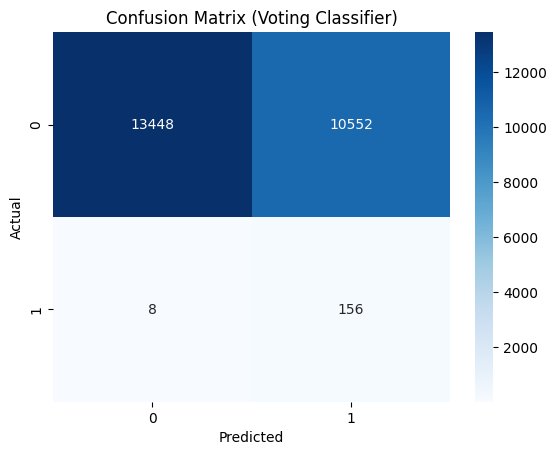

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.base import clone

# --- Logistic Regression ---
lr5 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.01,
    class_weight={0: 1, 1: 600},
    max_iter=1000,
    random_state=42
)

# --- Random Forest ---
rf = RandomForestClassifier(
    n_estimators=400,
    class_weight={0: 1.0, 1: 600.0},
    max_depth=7,
    max_features='log2',
    min_samples_leaf=3,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# --- XGBoost ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=1.0,
    reg_lambda=2.0,
    scale_pos_weight=600.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Fit XGBoost separately (on SMOTE data)
xgb.fit(X_smote, y_smote)

# Fit LR and RF on original training data
lr5.fit(X_train_proc, y_train)
rf.fit(X_train_proc, y_train)

# Predict probabilities on validation set from all models
proba_lr = lr5.predict_proba(X_val_proc)[:, 1]
proba_rf = rf.predict_proba(X_val_proc)[:, 1]
proba_xgb = xgb.predict_proba(X_val_proc)[:, 1]

# Average probabilities (soft voting)
import numpy as np
proba_avg = (proba_lr + proba_rf + proba_xgb) / 3
y_pred = (proba_avg >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import recall_score, f1_score, average_precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📈 Ensemble Voting Classifier (Soft Voting) on Validation Set:")
print(f"Recall (macro):     {recall_score(y_val, y_pred, average='macro'):.4f}")
print(f"F1-score (macro):   {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"PR-AUC:             {average_precision_score(y_val, proba_avg):.4f}")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Voting Classifier)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Permutation Importance 

### Summary columns

Train
📈 Validation Results:
Recall (macro):     0.5069
F1-score (macro):   0.0306
PR-AUC:             0.0106
              precision    recall  f1-score   support

           0       1.00      0.02      0.05    112000
           1       0.01      0.99      0.01       768

    accuracy                           0.03    112768
   macro avg       0.50      0.51      0.03    112768
weighted avg       0.99      0.03      0.05    112768



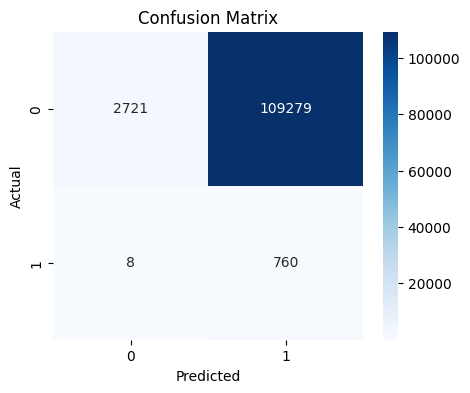

validation
📈 Validation Results:
Recall (macro):     0.5115
F1-score (macro):   0.0294
PR-AUC:             0.0099
              precision    recall  f1-score   support

           0       1.00      0.02      0.04     24000
           1       0.01      1.00      0.01       164

    accuracy                           0.03     24164
   macro avg       0.50      0.51      0.03     24164
weighted avg       0.99      0.03      0.04     24164



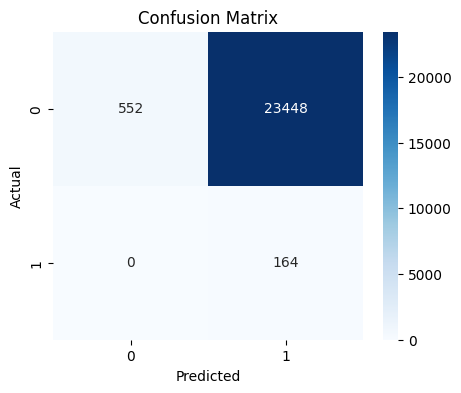

In [173]:
lr =  LogisticRegression(penalty='l1', solver='liblinear', C=0.01, class_weight={0: 1, 1: 600}, max_iter=1000, random_state=42)
columns = sum_cols
lr.fit(X_train_proc[columns],y_train)
print("Train")
evaluate_model(lr, X_train_proc[columns], y_train)
print("validation")
evaluate_model(lr, X_val_proc[columns], y_val)

### rev columns

Train
📈 Validation Results:
Recall (macro):     0.7052
F1-score (macro):   0.3205
PR-AUC:             0.0268
              precision    recall  f1-score   support

           0       1.00      0.45      0.62    112000
           1       0.01      0.96      0.02       768

    accuracy                           0.45    112768
   macro avg       0.51      0.71      0.32    112768
weighted avg       0.99      0.45      0.61    112768



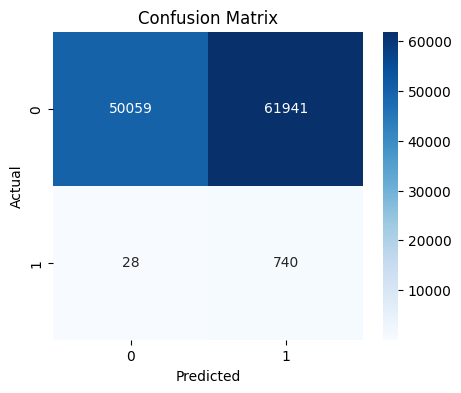

validation
📈 Validation Results:
Recall (macro):     0.6998
F1-score (macro):   0.3210
PR-AUC:             0.0143
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     24000
           1       0.01      0.95      0.02       164

    accuracy                           0.45     24164
   macro avg       0.51      0.70      0.32     24164
weighted avg       0.99      0.45      0.61     24164



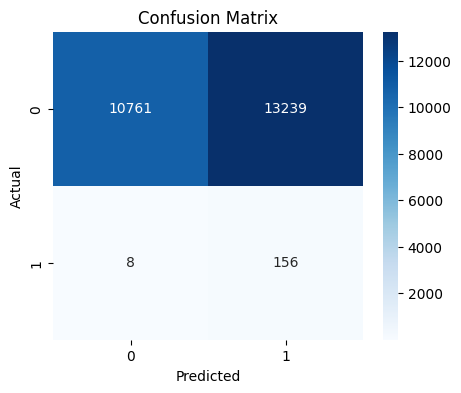

In [179]:
lr =  LogisticRegression(penalty='l1', solver='liblinear', C=0.01, class_weight={0: 1, 1: 600}, max_iter=1000, random_state=42)
columns = rev_cols
lr.fit(X_train_proc[columns],y_train)
print("Train")
evaluate_model(lr, X_train_proc[columns], y_train)
print("validation")
evaluate_model(lr, X_val_proc[columns], y_val)

Train
📈 Validation Results:
Recall (macro):     0.7073
F1-score (macro):   0.3244
PR-AUC:             0.0283
              precision    recall  f1-score   support

           0       1.00      0.45      0.63    112000
           1       0.01      0.96      0.02       768

    accuracy                           0.46    112768
   macro avg       0.51      0.71      0.32    112768
weighted avg       0.99      0.46      0.62    112768



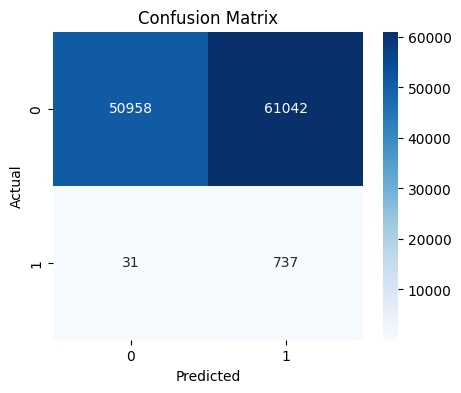

validation
📈 Validation Results:
Recall (macro):     0.6965
F1-score (macro):   0.3265
PR-AUC:             0.0153
              precision    recall  f1-score   support

           0       1.00      0.46      0.63     24000
           1       0.01      0.93      0.02       164

    accuracy                           0.46     24164
   macro avg       0.51      0.70      0.33     24164
weighted avg       0.99      0.46      0.63     24164



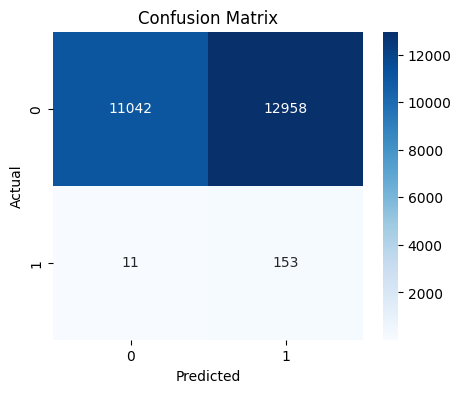

In [181]:
lr =  LogisticRegression(penalty='l1', solver='liblinear', C=0.01, class_weight={0: 1, 1: 600}, max_iter=1000, random_state=42)
columns = rev_cols + sum_cols
lr.fit(X_train_proc[columns],y_train)
print("Train")
evaluate_model(lr, X_train_proc[columns], y_train)
print("validation")
evaluate_model(lr, X_val_proc[columns], y_val)

Train
📈 Validation Results:
Recall (macro):     0.5876
F1-score (macro):   0.1647
PR-AUC:             0.0230
              precision    recall  f1-score   support

           0       1.00      0.19      0.31    112000
           1       0.01      0.99      0.02       768

    accuracy                           0.19    112768
   macro avg       0.50      0.59      0.16    112768
weighted avg       0.99      0.19      0.31    112768



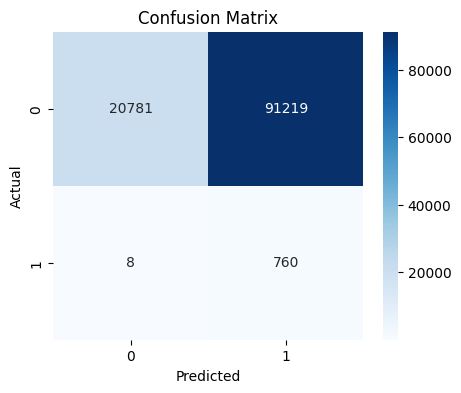

validation
📈 Validation Results:
Recall (macro):     0.5806
F1-score (macro):   0.1646
PR-AUC:             0.0234
              precision    recall  f1-score   support

           0       1.00      0.19      0.31     24000
           1       0.01      0.98      0.02       164

    accuracy                           0.19     24164
   macro avg       0.50      0.58      0.16     24164
weighted avg       0.99      0.19      0.31     24164



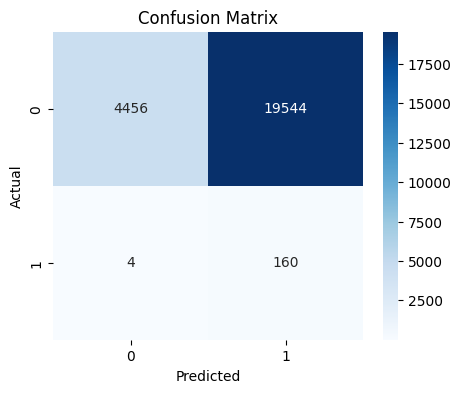

In [185]:
lr =  LogisticRegression(penalty='l1', solver='liblinear', C=0.01, class_weight={0: 1, 1: 600}, max_iter=1000, random_state=42)
columns = cat_cols
lr.fit(X_train_proc[columns],y_train)
print("Train")
evaluate_model(lr, X_train_proc[columns], y_train)
print("validation")
evaluate_model(lr, X_val_proc[columns], y_val)

Train
📈 Validation Results:
Recall (macro):     0.8238
F1-score (macro):   0.4741
PR-AUC:             0.0848
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    112000
           1       0.03      0.84      0.06       768

    accuracy                           0.81    112768
   macro avg       0.51      0.82      0.47    112768
weighted avg       0.99      0.81      0.89    112768



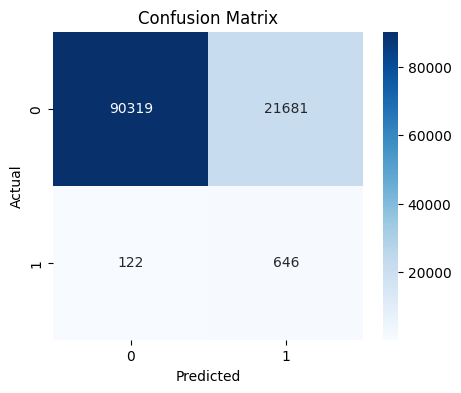

validation
📈 Validation Results:
Recall (macro):     0.7736
F1-score (macro):   0.4694
PR-AUC:             0.0304
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     24000
           1       0.03      0.74      0.05       164

    accuracy                           0.80     24164
   macro avg       0.51      0.77      0.47     24164
weighted avg       0.99      0.80      0.88     24164



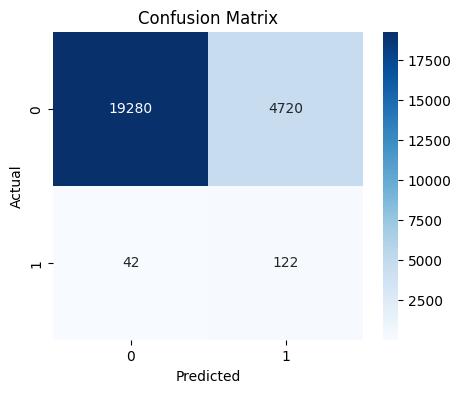

In [195]:
lr =  LogisticRegression(penalty='l1', solver='liblinear', C=0.01, class_weight="balanced", max_iter=1000, random_state=42)
columns = rev_cols+sum_cols+cat_cols+num_cols
lr.fit(X_train_proc[columns],y_train)
print("Train")
evaluate_model(lr, X_train_proc[columns], y_train)
print("validation")
evaluate_model(lr, X_val_proc[columns], y_val)

Train
📈 Validation Results:
Recall (macro):     0.8544
F1-score (macro):   0.4475
PR-AUC:             0.1877
              precision    recall  f1-score   support

           0       1.00      0.73      0.85    112000
           1       0.02      0.97      0.05       768

    accuracy                           0.74    112768
   macro avg       0.51      0.85      0.45    112768
weighted avg       0.99      0.74      0.84    112768



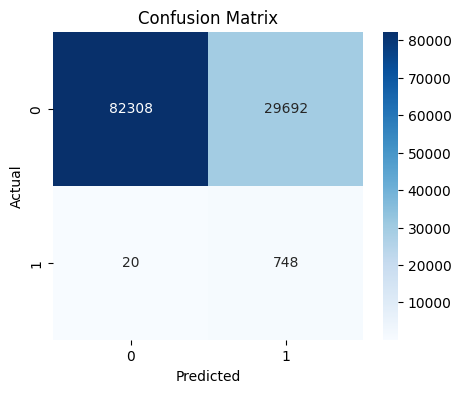

validation
📈 Validation Results:
Recall (macro):     0.7948
F1-score (macro):   0.4424
PR-AUC:             0.0544
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     24000
           1       0.02      0.86      0.04       164

    accuracy                           0.73     24164
   macro avg       0.51      0.79      0.44     24164
weighted avg       0.99      0.73      0.84     24164



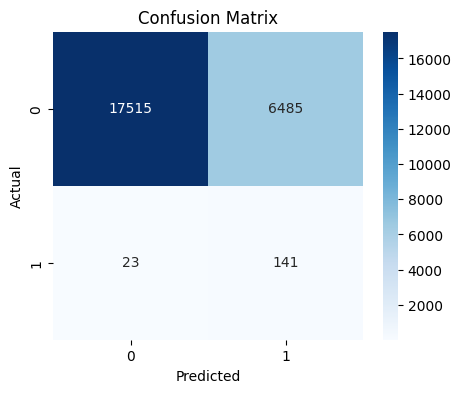

In [203]:
from sklearn.ensemble import VotingClassifier

# Train separate models with different class weights
lr_600 = LogisticRegression(C=0.01, penalty='l1', solver='liblinear',
                            class_weight={0: 1, 1: 600}, max_iter=1000, random_state=42)
lr_bal = LogisticRegression(C=0.01, penalty='l1', solver='liblinear',
                            class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(
    class_weight={0: 1.0, 1: 600.0}, max_depth=7,
    max_features='log2', min_samples_leaf=3,
    min_samples_split=5, n_estimators=400,
    random_state=42, n_jobs=-1)

rf2 = RandomForestClassifier(
    class_weight={0: 1.0, 1: 145.0}, max_depth=7,
    max_features='log2', min_samples_leaf=3,
    min_samples_split=5, n_estimators=400,
    random_state=42, n_jobs=-1)

xgb_base = XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.6,
    reg_alpha=1.0, reg_lambda=2.0,
    scale_pos_weight=600.0,
    use_label_encoder=False, eval_metric='logloss',
    random_state=42, n_jobs=-1)

voting = VotingClassifier(
    estimators=[('lr600', lr_600), ('lr_bal', lr_bal),('rf',rf),('rf2',rf2),('xgb_base',xgb_base)],
    voting='soft', 
    n_jobs=-1
)

voting.fit(X_train_proc, y_train)
print("Train")
evaluate_model(voting, X_train_proc, y_train)
print("validation")
evaluate_model(voting, X_val_proc, y_val)

Train
📈 Validation Results:
Recall (macro):     0.8400
F1-score (macro):   0.4386
PR-AUC:             0.1790
              precision    recall  f1-score   support

           0       1.00      0.71      0.83    112000
           1       0.02      0.97      0.04       768

    accuracy                           0.72    112768
   macro avg       0.51      0.84      0.44    112768
weighted avg       0.99      0.72      0.83    112768



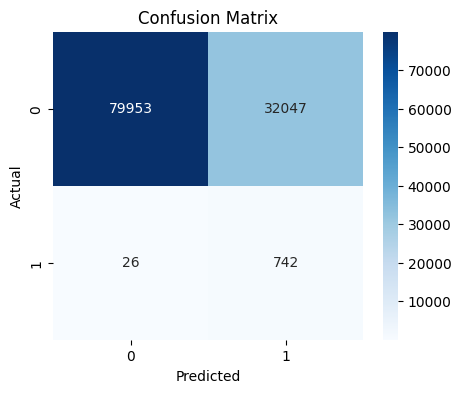

validation
📈 Validation Results:
Recall (macro):     0.7882
F1-score (macro):   0.4348
PR-AUC:             0.0461
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     24000
           1       0.02      0.87      0.04       164

    accuracy                           0.71     24164
   macro avg       0.51      0.79      0.43     24164
weighted avg       0.99      0.71      0.83     24164



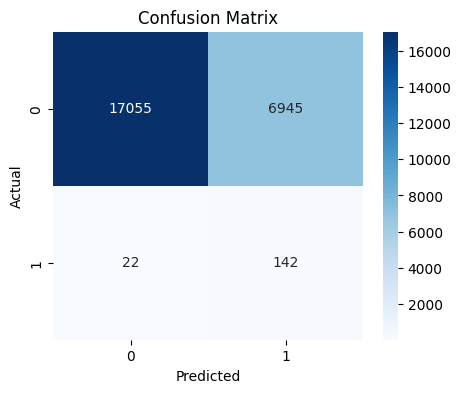

In [209]:
columns = sum_cols+rev_cols+num_cols
voting.fit(X_train_proc[columns], y_train)
print("Train")
evaluate_model(voting, X_train_proc[columns], y_train)
print("validation")
evaluate_model(voting, X_val_proc[columns], y_val)

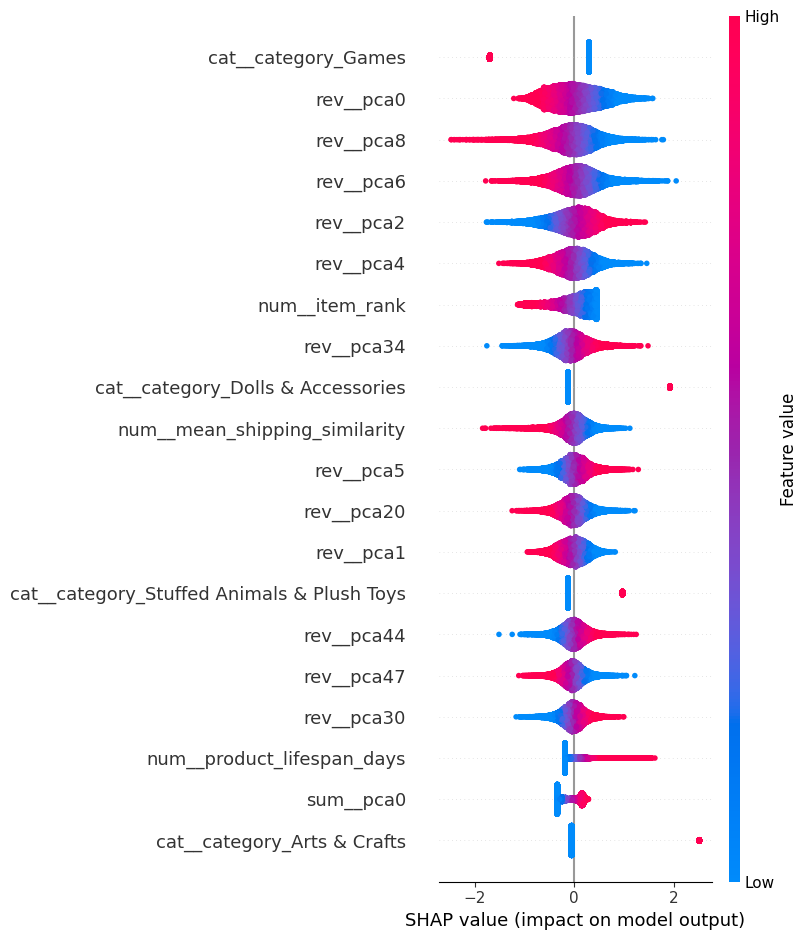

In [211]:
from sklearn.linear_model import LogisticRegression

lr5 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.01,
    class_weight={0: 1, 1: 600},
    max_iter=1000,
    random_state=42
)

lr5.fit(X_train_proc, y_train)

import shap

explainer = shap.Explainer(lr5, X_train_proc, feature_perturbation="interventional")
shap_values = explainer(X_val_proc)
shap.summary_plot(shap_values, X_val_proc, max_display=20)


Train
📈 Validation Results:
Recall (macro):     0.7734
F1-score (macro):   0.3815
PR-AUC:             0.0736
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    112000
           1       0.02      0.97      0.03       768

    accuracy                           0.58    112768
   macro avg       0.51      0.77      0.38    112768
weighted avg       0.99      0.58      0.73    112768



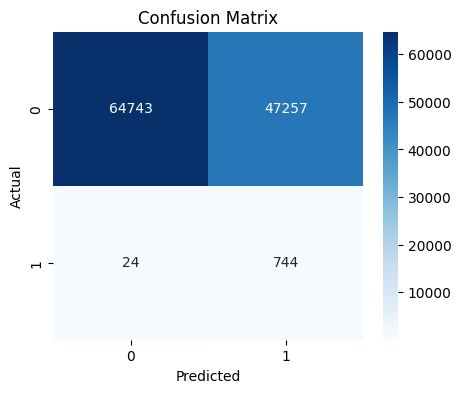

validation
📈 Validation Results:
Recall (macro):     0.7534
F1-score (macro):   0.3790
PR-AUC:             0.0328
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     24000
           1       0.01      0.93      0.03       164

    accuracy                           0.58     24164
   macro avg       0.51      0.75      0.38     24164
weighted avg       0.99      0.58      0.72     24164



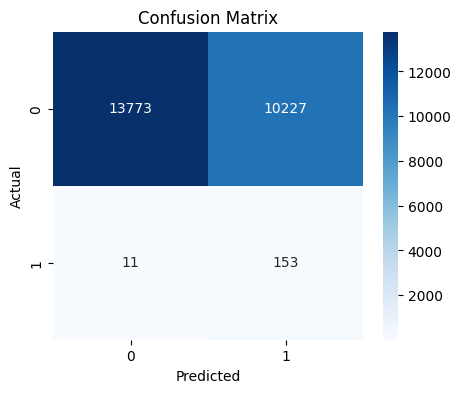

In [215]:
# mean absolute SHAP value per feature
mean_abs_shap = pd.DataFrame(shap_values.values, columns=X_val_proc.columns).abs().mean()

# Select low importance features (bottom 20 here)
low_shap_feats = mean_abs_shap.sort_values().head(20).index.tolist()

X_train_refined = X_train_proc.drop(columns=low_shap_feats)
X_val_refined   = X_val_proc.drop(columns=low_shap_feats)

lr5.fit(X_train_refined, y_train)
print("Train")
evaluate_model(lr5, X_train_refined, y_train)
print("validation")
evaluate_model(lr5, X_val_refined, y_val)

Train
📈 Validation Results:
Recall (macro):     0.7704
F1-score (macro):   0.3805
PR-AUC:             0.0731
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    112000
           1       0.02      0.96      0.03       768

    accuracy                           0.58    112768
   macro avg       0.51      0.77      0.38    112768
weighted avg       0.99      0.58      0.73    112768



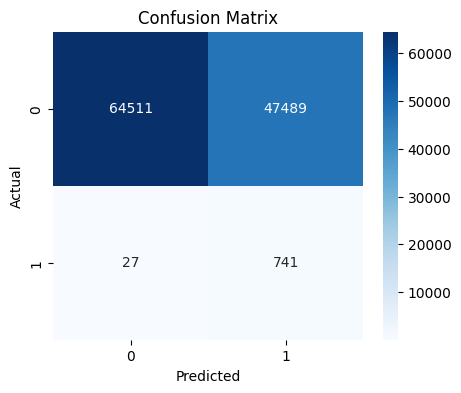

validation
📈 Validation Results:
Recall (macro):     0.7529
F1-score (macro):   0.3786
PR-AUC:             0.0327
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     24000
           1       0.01      0.93      0.03       164

    accuracy                           0.58     24164
   macro avg       0.51      0.75      0.38     24164
weighted avg       0.99      0.58      0.72     24164



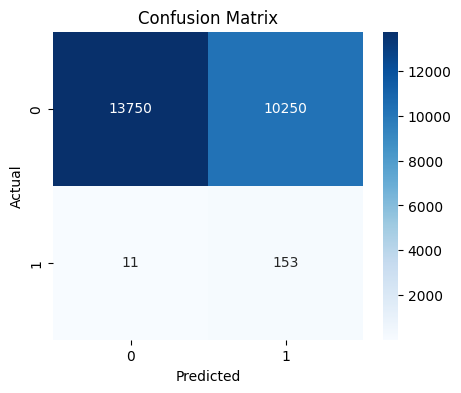

In [219]:
# Select low importance features (bottom 20 here)
low_shap_feats = mean_abs_shap.sort_values().head(30).index.tolist()

X_train_refined = X_train_proc.drop(columns=low_shap_feats)
X_val_refined   = X_val_proc.drop(columns=low_shap_feats)

lr5.fit(X_train_refined, y_train)
print("Train")
evaluate_model(lr5, X_train_refined, y_train)
print("validation")
evaluate_model(lr5, X_val_refined, y_val)

📊 CV Recall (macro): 0.6633 ± 0.0537
📈 Train Evaluation:
📈 Validation Results:
Recall (macro):     0.7704
F1-score (macro):   0.3805
PR-AUC:             0.0731
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    112000
           1       0.02      0.96      0.03       768

    accuracy                           0.58    112768
   macro avg       0.51      0.77      0.38    112768
weighted avg       0.99      0.58      0.73    112768



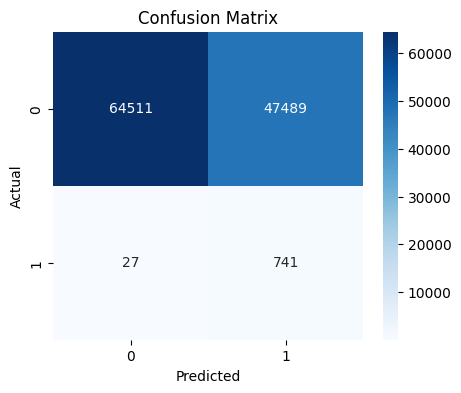

📈 Validation Evaluation:
📈 Validation Results:
Recall (macro):     0.7529
F1-score (macro):   0.3786
PR-AUC:             0.0327
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     24000
           1       0.01      0.93      0.03       164

    accuracy                           0.58     24164
   macro avg       0.51      0.75      0.38     24164
weighted avg       0.99      0.58      0.72     24164



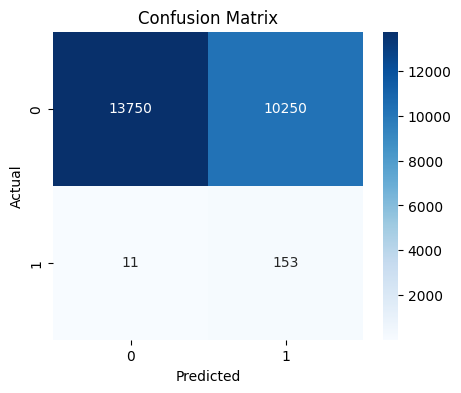

In [221]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, f1_score, average_precision_score, classification_report

# Define low SHAP features
low_shap_feats = mean_abs_shap.sort_values().head(30).index.tolist()

# Drop them
X_train_refined = X_train_proc.drop(columns=low_shap_feats)
X_val_refined   = X_val_proc.drop(columns=low_shap_feats)

# Refit
lr5.fit(X_train_refined, y_train)

# --- Cross-Validation (macro recall) ---
cv_recall_scores = cross_val_score(
    lr5, X_train_refined, y_train, cv=kfold, scoring='recall_macro'
)
print(f"📊 CV Recall (macro): {cv_recall_scores.mean():.4f} ± {cv_recall_scores.std():.4f}")

# --- Train Evaluation ---
print("📈 Train Evaluation:")
evaluate_model(lr5, X_train_refined, y_train)

# --- Validation Evaluation ---
print("📈 Validation Evaluation:")
evaluate_model(lr5, X_val_refined, y_val)


📊 CV Recall (macro): 0.6593 ± 0.0488
📈 Train Evaluation:
📈 Validation Results:
Recall (macro):     0.7736
F1-score (macro):   0.3827
PR-AUC:             0.0738
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    112000
           1       0.02      0.97      0.03       768

    accuracy                           0.58    112768
   macro avg       0.51      0.77      0.38    112768
weighted avg       0.99      0.58      0.73    112768



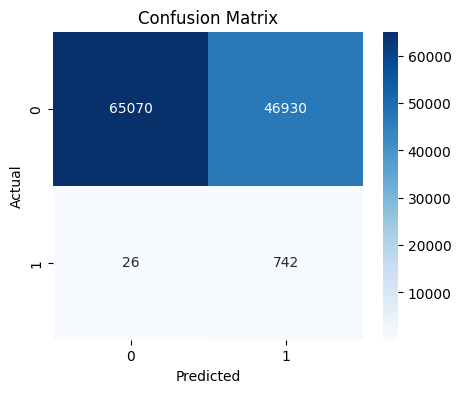

📈 Validation Evaluation:
📈 Validation Results:
Recall (macro):     0.7517
F1-score (macro):   0.3801
PR-AUC:             0.0321
              precision    recall  f1-score   support

           0       1.00      0.58      0.73     24000
           1       0.01      0.93      0.03       164

    accuracy                           0.58     24164
   macro avg       0.51      0.75      0.38     24164
weighted avg       0.99      0.58      0.73     24164



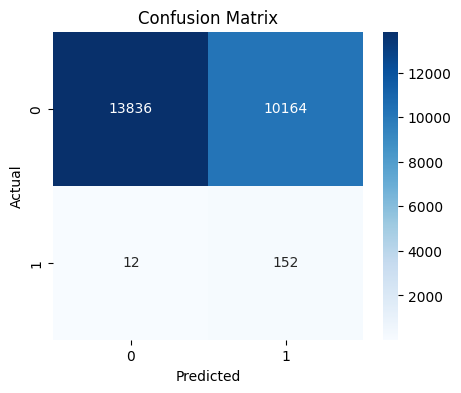

In [223]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, f1_score, average_precision_score, classification_report

# Define low SHAP features
low_shap_feats = mean_abs_shap.sort_values().head(1).index.tolist()

# Drop them
X_train_refined = X_train_proc.drop(columns=low_shap_feats)
X_val_refined   = X_val_proc.drop(columns=low_shap_feats)

# Refit
lr5.fit(X_train_refined, y_train)

# --- Cross-Validation (macro recall) ---
cv_recall_scores = cross_val_score(
    lr5, X_train_refined, y_train, cv=kfold, scoring='recall_macro'
)
print(f"📊 CV Recall (macro): {cv_recall_scores.mean():.4f} ± {cv_recall_scores.std():.4f}")

# --- Train Evaluation ---
print("📈 Train Evaluation:")
evaluate_model(lr5, X_train_refined, y_train)

# --- Validation Evaluation ---
print("📈 Validation Evaluation:")
evaluate_model(lr5, X_val_refined, y_val)

CV Recall (macro): 0.6633 ± 0.0537
Train Evaluation:
📈 Validation Results:
Recall (macro):     0.7704
F1-score (macro):   0.3805
PR-AUC:             0.0731
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    112000
           1       0.02      0.96      0.03       768

    accuracy                           0.58    112768
   macro avg       0.51      0.77      0.38    112768
weighted avg       0.99      0.58      0.73    112768



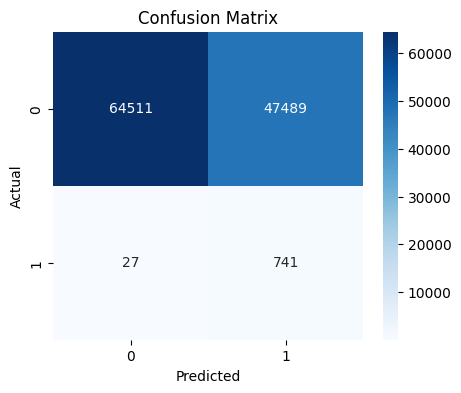

 Validation Evaluation:
📈 Validation Results:
Recall (macro):     0.7529
F1-score (macro):   0.3786
PR-AUC:             0.0327
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     24000
           1       0.01      0.93      0.03       164

    accuracy                           0.58     24164
   macro avg       0.51      0.75      0.38     24164
weighted avg       0.99      0.58      0.72     24164



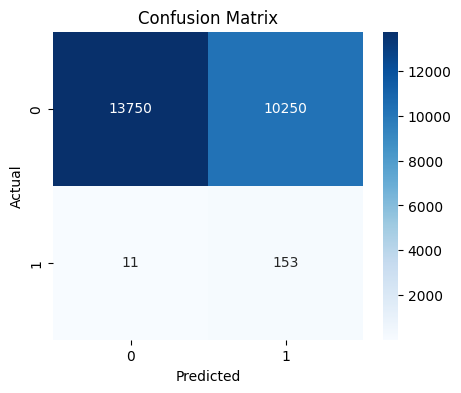

In [239]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, f1_score, average_precision_score, classification_report

# Define low SHAP features
low_shap_feats = mean_abs_shap.sort_values().head(30).index.tolist()

# Drop them
X_train_refined = X_train_proc.drop(columns=low_shap_feats)
X_val_refined   = X_val_proc.drop(columns=low_shap_feats)

# Refit
lr5.fit(X_train_refined, y_train)

# --- Cross-Validation (macro recall) ---
cv_recall_scores = cross_val_score(
    lr5, X_train_refined, y_train, cv=kfold, scoring='recall_macro'
)
print(f"CV Recall (macro): {cv_recall_scores.mean():.4f} ± {cv_recall_scores.std():.4f}")

# --- Train Evaluation ---
print("Train Evaluation:")
evaluate_model(lr5, X_train_refined, y_train)

# --- Validation Evaluation ---
print(" Validation Evaluation:")
evaluate_model(lr5, X_val_refined, y_val)

Train
📈 Validation Results:
Recall (macro):     0.8533
F1-score (macro):   0.4476
PR-AUC:             0.1831
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    112000
           1       0.02      0.97      0.05       768

    accuracy                           0.74    112768
   macro avg       0.51      0.85      0.45    112768
weighted avg       0.99      0.74      0.84    112768



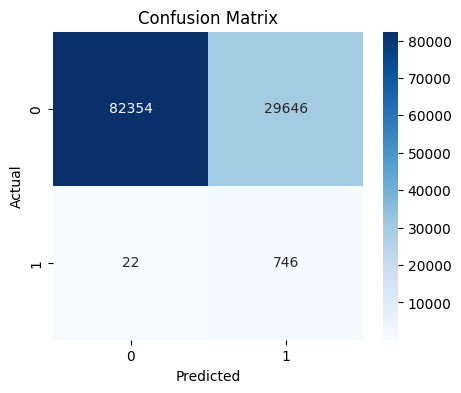

validation
📈 Validation Results:
Recall (macro):     0.7952
F1-score (macro):   0.4428
PR-AUC:             0.0480
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     24000
           1       0.02      0.86      0.04       164

    accuracy                           0.73     24164
   macro avg       0.51      0.80      0.44     24164
weighted avg       0.99      0.73      0.84     24164



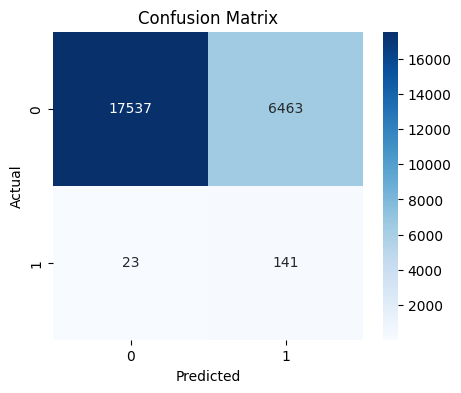

In [241]:
voting.fit(X_train_refined, y_train)
print("Train")
evaluate_model(voting, X_train_refined, y_train)
print("validation")
evaluate_model(voting, X_val_refined, y_val)

In [233]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score

def evaluate_model_cv(model, X, y, cv, model_name="Model"):
    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scorers,
        return_train_score=False,
        n_jobs=-1
    )
    print(f" Cross-Validation Results ({model_name}):")
    for key in scorers.keys():
        mean_score = cv_results[f'test_{key}'].mean()
        std_score = cv_results[f'test_{key}'].std()
        print(f"{key}: {mean_score:.4f} ± {std_score:.4f}")

    return cv_results



In [245]:
evaluate_model_cv(voting, X_train_refined, y_train, kfold, model_name="Model")

 Cross-Validation Results (Model):
recall_macro: 0.6417 ± 0.0492
f1_macro: 0.4561 ± 0.0113
pr_auc: 0.0456 ± 0.0120


{'fit_time': array([53.59068966, 51.56637192, 72.06126118]),
 'score_time': array([0.59397292, 0.54976487, 0.37763238]),
 'test_recall_macro': array([0.71019843, 0.61779149, 0.59711325]),
 'test_f1_macro': array([0.45356928, 0.44369348, 0.47095204]),
 'test_pr_auc': array([0.03267964, 0.04262816, 0.06153163])}

Train
📈 Validation Results:
Recall (macro):     0.8636
F1-score (macro):   0.4455
PR-AUC:             0.2212
              precision    recall  f1-score   support

           0       1.00      0.73      0.84    112000
           1       0.02      1.00      0.05       768

    accuracy                           0.73    112768
   macro avg       0.51      0.86      0.45    112768
weighted avg       0.99      0.73      0.84    112768



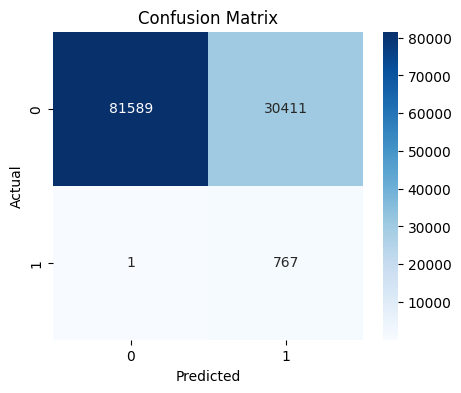

validation
📈 Validation Results:
Recall (macro):     0.7800
F1-score (macro):   0.4397
PR-AUC:             0.0437
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     24000
           1       0.02      0.84      0.04       164

    accuracy                           0.73     24164
   macro avg       0.51      0.78      0.44     24164
weighted avg       0.99      0.73      0.83     24164



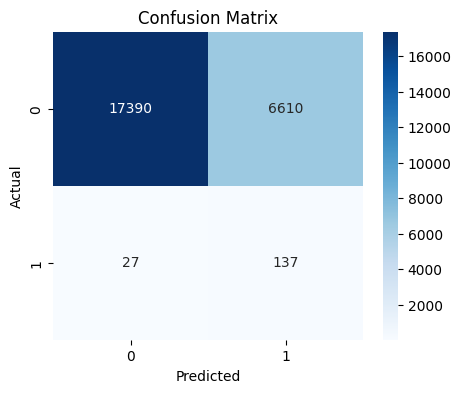

In [247]:
# --- XGBoost ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=1.0,
    reg_lambda=2.0,
    scale_pos_weight=600.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_refined, y_train)
print("Train")
evaluate_model(xgb, X_train_refined, y_train)
print("validation")
evaluate_model(xgb, X_val_refined, y_val)

In [249]:
X_train_refined.shape

(112768, 65)

In [253]:
evaluate_model_cv(xgb, X_train_refined, y_train, kfold, model_name="xgboost")

 Cross-Validation Results (xgboost):
recall_macro: 0.6200 ± 0.0480
f1_macro: 0.4583 ± 0.0095
pr_auc: 0.0335 ± 0.0097


{'fit_time': array([2.66534853, 2.77329612, 3.42654061]),
 'score_time': array([0.11821961, 0.13058615, 0.06213188]),
 'test_recall_macro': array([0.68623659, 0.59964167, 0.57409801]),
 'test_f1_macro': array([0.45887574, 0.44642879, 0.46971711]),
 'test_pr_auc': array([0.02665556, 0.0265912 , 0.04713091])}

In [255]:
evaluate_model_cv(xgb, X_train_proc, y_train, kfold, model_name="xgboost")

 Cross-Validation Results (xgboost):
recall_macro: 0.6219 ± 0.0516
f1_macro: 0.4595 ± 0.0074
pr_auc: 0.0346 ± 0.0088


{'fit_time': array([3.72385406, 3.56015801, 4.70214319]),
 'score_time': array([0.13376832, 0.13291335, 0.07555008]),
 'test_recall_macro': array([0.6897522 , 0.6111045 , 0.56474981]),
 'test_f1_macro': array([0.45879533, 0.45078406, 0.46881   ]),
 'test_pr_auc': array([0.02812135, 0.02860358, 0.04696973])}

In [257]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score

# Define scoring metrics (excluding PR-AUC since LinearSVC lacks predict_proba)
svm_scorers = {
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

# Initialize LinearSVC
svm = LinearSVC(
    penalty='l2',
    C=1.0,
    class_weight={0: 1, 1: 600},
    max_iter=10000,
    random_state=42
)

# Run CV
svm_cv_results = cross_validate(
    svm,
    X_train_refined,
    y_train,
    cv=kfold,
    scoring=svm_scorers,
    return_train_score=False,
    n_jobs=-1
)

# Report
print("📊 Cross-Validation Results (LinearSVC):")
for key in svm_scorers:
    mean_score = svm_cv_results[f'test_{key}'].mean()
    std_score = svm_cv_results[f'test_{key}'].std()
    print(f"{key}: {mean_score:.4f} ± {std_score:.4f}")


📊 Cross-Validation Results (LinearSVC):
recall_macro: 0.6556 ± 0.0642
f1_macro: 0.3839 ± 0.0272


In [265]:
svm.fit(X_train_refined, y_train)
confusion_matrix(y_val,svm.predict(X_val_refined))


array([[13362, 10638],
       [    8,   156]], dtype=int64)

In [273]:
y_pred_xgb = xgb.predict(X_val_refined)
y_pred_lr  = lr5.predict(X_val_refined)


In [275]:
# Where both models predicted 1
both_1 = (y_pred_xgb == 1) & (y_pred_lr == 1)

# Where both models predicted 0
both_0 = (y_pred_xgb == 0) & (y_pred_lr == 0)

# Total same predictions (intersection)
same_preds = (y_pred_xgb == y_pred_lr)


📈 Validation Results:
Recall (macro):     0.6750
F1-score (macro):   0.3746
PR-AUC:             0.0109
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     24000
           1       0.01      0.78      0.02       164

    accuracy                           0.57     24164
   macro avg       0.50      0.68      0.37     24164
weighted avg       0.99      0.57      0.72     24164



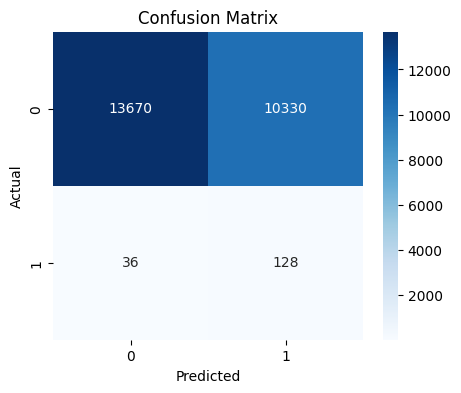

In [283]:
lr = LogisticRegression(
    penalty='l2',
    solver='saga',
    C=0.01,
    class_weight={0: 1, 1: 600},
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_proc, y_train)  
evaluate_model(lr, X_val_proc, y_val)

📈 Validation Results:
Recall (macro):     0.7443
F1-score (macro):   0.4340
PR-AUC:             0.0269
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     24000
           1       0.02      0.77      0.04       164

    accuracy                           0.71     24164
   macro avg       0.51      0.74      0.43     24164
weighted avg       0.99      0.71      0.83     24164



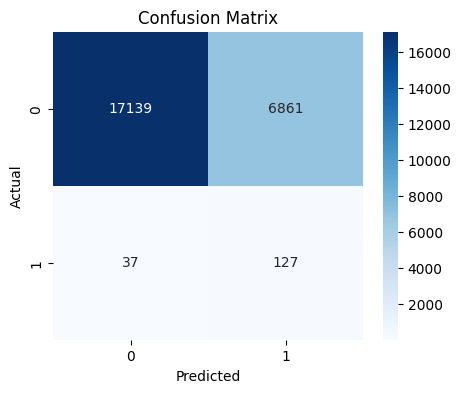

In [285]:
lr = LogisticRegression(
    penalty='l2',
    solver='saga',
    C=0.01,
    class_weight={0: 1, 1: 250},
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_proc, y_train)  
evaluate_model(lr, X_val_proc, y_val)

In [291]:
sum(y_val==0)/sum(y_val==1)

146.34146341463415